# Single-subject brain decoding using multi[variate/voxel]-pattern analysis (MVPA)

- Andrew J. Graves
- 12/1/22

In [1]:
# Import modules
import os
import glob
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut

from nilearn.image import load_img, iter_img, binarize_img, threshold_img, \
    mean_img, concat_imgs
from nilearn.maskers import NiftiMasker
from nilearn.decoding import Decoder
from nilearn.plotting import plot_glass_brain, view_img

# Specify base location of input files
base_dir = '/project/morrislab/Andrew'

# Specify name for results directory
out_dir = 'decoding_results'

# Whether or not to apply a mask to the decoder
apply_mask = True

# Determine if hyperparameters should be tuned or not
tune_params = False

# Specify if data was collected over multiple runs
is_multi_run = True

# Standardize inputs during training
standardize_features = True

# Specify number of cores for each subject (# requested from HPC, important!)
n_cores = 16

# For high-resolution plot display
plt.rcParams['figure.dpi'] = 300

## Specify file locations and parameters for the classifier

- Single-trial beta-series files using least-squares-all (LSA) are output from the *first_level_from_bids.ipynb*

In [2]:
# Directory for beta-series results
beta_series_in = f'{base_dir}/glm/beta_series_results/'

# Task name used for decoding
task_label = 'faceflower'

# Fetch all beta-series file names
beta_series_files = glob.glob(f'{beta_series_in}*{task_label}*.pkl')

# Specify decoding tasks as a dictionary of contrasts (str: list of lists)
# Names within the lists must correspond to column names in the design matrices
decode_tasks = {'all_face_flower': [
                    ['face', 'faceOld', 'faceNew'],
                    ['flower', 'flowerOld', 'flowerNew']],
                
                'recog_face_flower': [
                    ['faceOld', 'faceNew'],
                    ['flowerOld', 'flowerNew']],
                
                'encode_face_flower': [
                    ['face'],
                    ['flower']]
               }

# Choose percentage of voxels to keep with univariate feature selection
# This is w.r.t to the entire brain, not just the mask
# Note that with masked data, this could still include all of the voxels within 
# the mask depending on its size, which could actually be desirable
voxel_percentile = 10

# Specify size of smoothing (None is an option)
fwhm = 4

# Specify which score function to use
# If classes are highly imbalanced: consider using precision, recall, or f1
# Use roc_auc for assessing a variety of thresholded decision boundaries
score_func = 'accuracy'

# Specify number of runs (1 if single-run)
n_runs = 3

# Specify learning model implemented w/ nilearn (sklearn backend)
model = 'logistic_l2'
# Specify parameter grid (classifier specific, look at sklearn docs!)
param_grid = {'C': 10**np.linspace(3, -3, 20)}
# If parameters are not tuned
# Useful if you want each subject to receive same level of regularization
if not tune_params:
    param_grid = None

# Specify mask to apply to decoder (if desired)
mask = f'{base_dir}/neurosynth_masks/face_association-test_z_FDR_0.01.nii.gz'
# If no masking requested
if not apply_mask:
    mask = None

# Choose K for K-fold cross-validation (if single-run data)
k = 5
# Do leave-one-run out validation if multi-run
# Performance metrics could be inflated if train/test come from same run
if is_multi_run:
    k = LeaveOneGroupOut()

## Train the decoder

- Note that MVPA here is simply the application of supervised learning models to voxelwise fMRI GLM coefficients from event signals
- You can use either a whole-brain or region-of-interest (ROI) approach, with a univariate feature selection criterion within the cross-validation loop to screen out irrelevant voxels. Note that you apply a mask to the *Decoder* object in the exact same way you would with other nilearn objects to reduce the search space to apriori ROIs.

In [3]:
# Generate column names for output
cols = [f'{col}_decode_{score_func}' for col in list(decode_tasks.keys())]
cols.insert(0, 'subject_label')

# Initialize DataFrame for subject-specific decoding results
res_df = pd.DataFrame(columns=cols)

# Initialize storage for coefficient images
coef_imgs = {}

# Build masker if ROI analysis requested
if apply_mask:
    print(f'Applying the following mask file to brain images: {mask}')
    masker = NiftiMasker(
    binarize_img(mask),
    smoothing_fwhm=fwhm,
    standardize=standardize_features,
    memory='nilearn_cache', 
    memory_level=1)

# Iterate through all subjects
for idx, file in enumerate(beta_series_files):
    
     # Get subject identifer with regex
    subj_id = re.findall('sub-\d+', file)[0]
    print(f'\n--- Processing {subj_id}, iteration #{idx+1} ---\n')
    
    # Read in current subject beta-series
    with open(file, 'rb') as handle:
        beta_series_dict = pickle.load(handle)
        
    # Initialize subject-specific coefficient image dictionary
    coef_imgs[subj_id] = {}
    # Initialize output for classification performance
    perfs = []

    # Iterate through decoding tasks
    for keys, vals in decode_tasks.items():
        
        # --- Initialize containers:
        # All tasks to decode from one another
        task_list = []
        # Model training input
        z_maps = []
        # Number of examples
        n_examples = []
        # Run labels
        run_labels = []
        # ---
        
        # Iterate through labels within each contrast of interest
        for val in vals:
            # Get the the collection of task images
            task_img_coll = {key: beta_series_dict[key] for key in val 
                                 if key in beta_series_dict}
            # Concatenate within-task images with different event names
            task_imgs = concat_imgs(task_img_coll.values())

            # Add to task list 
            task_list.append(task_imgs)
            # Add number of volumes for this event type
            n_example = task_imgs.get_fdata().shape[-1]
            n_examples.append(n_example)
            
            # Generate run-labels
            # Assumes same number of stimuli of a given type per run!
            # Assumption was made because the inputs were previously 
            # concatenated across runs in first_level_from_bids.ipynb
            # This is a strong assumption and you should be careful with this
            # In my case, it is a safe assumption
            run_label = list(np.repeat(range(0, n_runs), 
                             n_example / n_runs))
            run_labels += run_label

        # Concatenate all of the coefficient images into a list named z_maps
        for task in task_list:
            for task_img in iter_img(task):
                z_maps.append(task_img)
        
        # Add labels to the images for the response variable
        condition_labels = np.repeat(range(0, len(task_list)), 
                                     repeats=n_examples)
        
        # Do k-fold instead of leave one-run-out if only one run
        if not is_multi_run:
            run_labels = None

        # Initialize the decoder in nilearn (sklearn wrapper)
        decoder = Decoder(estimator=model, 
                          mask=masker,
                          param_grid=param_grid,
                          scoring=score_func,
                          screening_percentile=voxel_percentile, 
                          smoothing_fwhm=fwhm,
                          standardize=standardize_features,
                          cv=k, 
                          n_jobs=n_cores)
        # Fit the classifier
        decoder.fit(z_maps, condition_labels, groups=run_labels)
        
        # Store coefficient images for each subject / task combination
        coef_imgs[subj_id][keys] = decoder.coef_img_

        # Return the corresponding mean prediction performance across CV
        perf = np.mean(list(decoder.cv_scores_.values()))
        perfs.append(perf)
        print(f'{score_func} for task {keys}: {perf:.3f}')
    
    # Add subject ID to classifcation results
    perfs.insert(0, subj_id)
    # Append current subject to decoding results
    res_df = res_df.append(pd.DataFrame([perfs], columns=cols), 
                           ignore_index=True)

# Check if output directory exists
if not os.path.exists(out_dir):
    # Make output directory
    os.mkdir(out_dir)

# Save full decoding results to file
res_df.to_csv(f'{out_dir}/decoding_results_{task_label}_{model}.csv', 
              index=False)

# Save coefficient images to file
with open(f'{out_dir}/coef_imgs_{task_label}_{model}.pkl', 'wb') as handle:
    pickle.dump(coef_imgs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Applying the following mask file to brain images: /project/morrislab/Andrew/neurosynth_masks/face_association-test_z_FDR_0.01.nii.gz

--- Processing sub-276, iteration #1 ---



/home/ajg3eh/.local/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


accuracy for task all_face_flower: 0.800
accuracy for task recog_face_flower: 0.792
accuracy for task encode_face_flower: 0.800

--- Processing sub-317, iteration #2 ---

accuracy for task all_face_flower: 0.811
accuracy for task recog_face_flower: 0.833
accuracy for task encode_face_flower: 0.867

--- Processing sub-284, iteration #3 ---

accuracy for task all_face_flower: 0.933
accuracy for task recog_face_flower: 0.925
accuracy for task encode_face_flower: 0.917

--- Processing sub-299, iteration #4 ---

accuracy for task all_face_flower: 0.956
accuracy for task recog_face_flower: 0.975
accuracy for task encode_face_flower: 0.883

--- Processing sub-348, iteration #5 ---

accuracy for task all_face_flower: 0.944
accuracy for task recog_face_flower: 0.958
accuracy for task encode_face_flower: 0.950

--- Processing sub-281, iteration #6 ---

accuracy for task all_face_flower: 0.761
accuracy for task recog_face_flower: 0.800
accuracy for task encode_face_flower: 0.567

--- Processing s

## Plot decoding results

This static image is the average of model coefficients across subjects and provides insight into which regions are most supporting the decoding process. These likely will look similar to results from a second-level model, but they will certainly not be identical for a variety of reasons, namely that second-level models are a sequence of univariate tests at each voxel, while decoders fit all voxels simultaneously. These image intensities reflect the contribution of a specific voxel above and beyond the effects of all the other voxels included in the model.

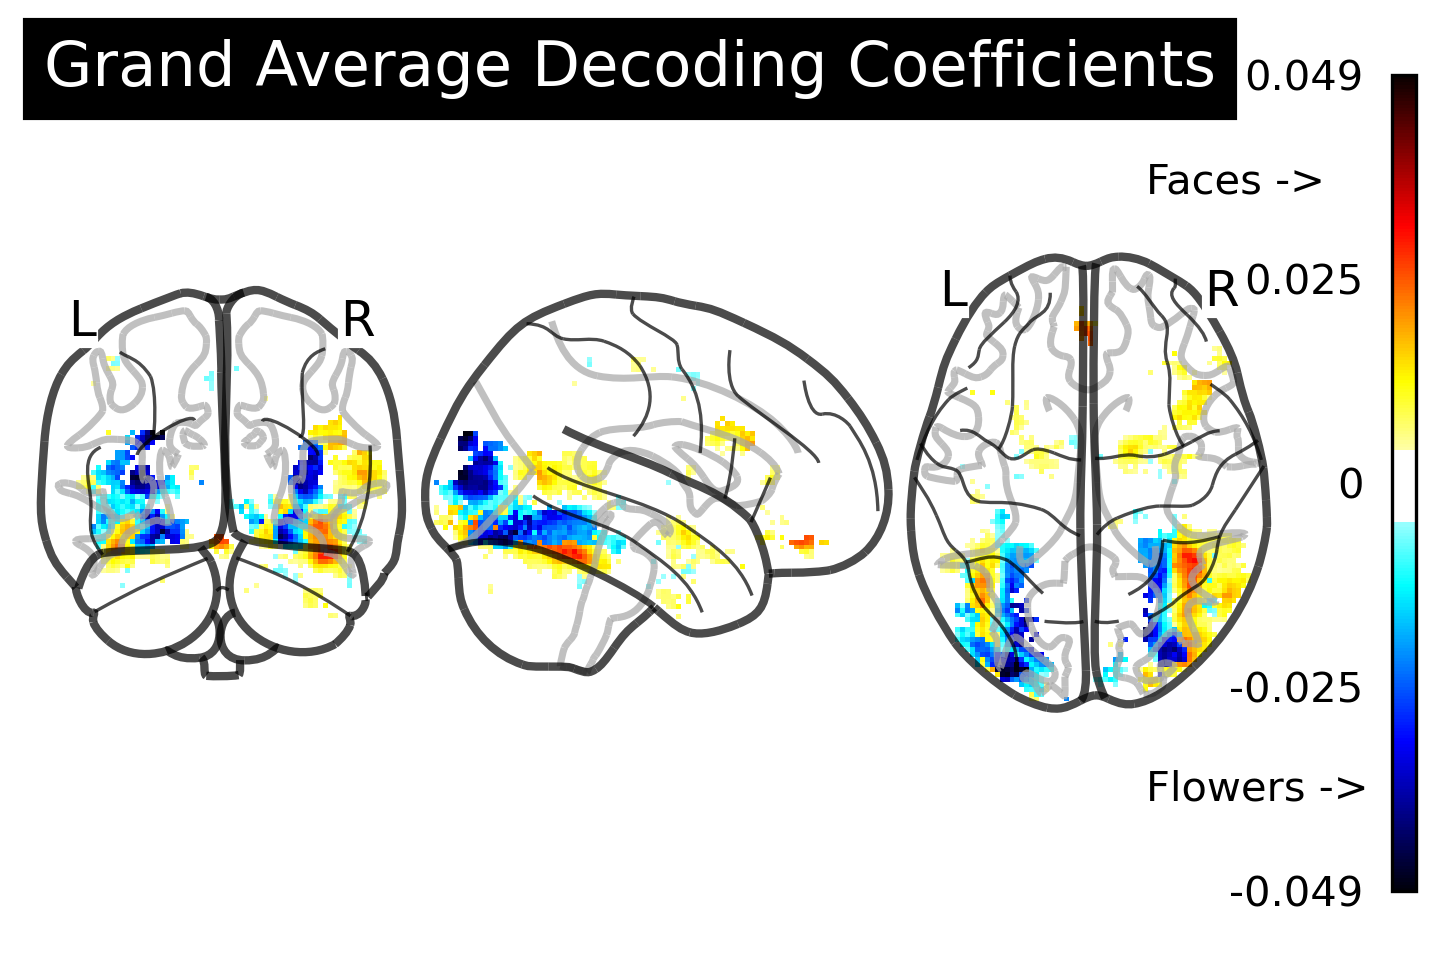

In [4]:
# Percentile to display voxel decoding results
thres_perc = 50

# Collect all images for a specific decoding task
# Pay attention to the index here to get the desired coefficients!
all_imgs = [imgs['all_face_flower'][1] for imgs in coef_imgs.values()]

# Take the mean of model weights across all subjects
weight_img = mean_img(all_imgs)

# Cast nifti data as vector
weight_vector = np.ravel(weight_img.get_fdata())

# Find non-zero values for relevant thresholding
non_zero_idx = np.argwhere(weight_vector)

# Get the value corresponding to specific threshold
thres = np.percentile(np.abs(weight_vector[non_zero_idx]), thres_perc)

# Plot the coefficients over a glass brain layout
fig, ax = plt.subplots()

plot_glass_brain(
        weight_img,
        threshold=thres,
        colorbar=True,
        black_bg=False,
        display_mode='ortho',
        plot_abs=False,
        axes=ax,
        title='Grand Average Decoding Coefficients'
    )

ax.text(x=.8, y=.82, s='Faces ->', color='black')
ax.text(x=.8, y=.15, s='Flowers ->', color='black');

We can view the same image interactively to better explore (sub-)cortical locations...

/home/ajg3eh/.local/lib/python3.8/site-packages/nilearn/plotting/html_stat_map.py:219: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



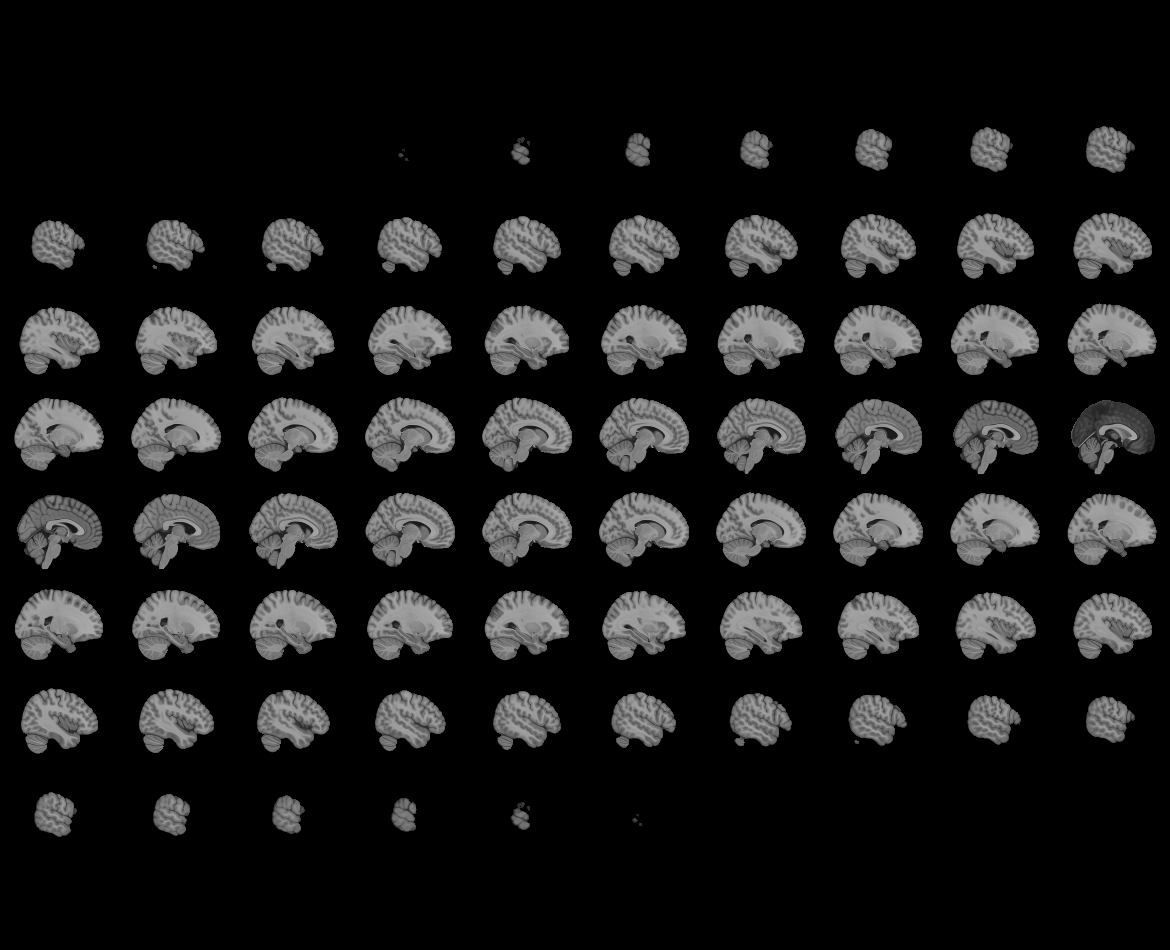
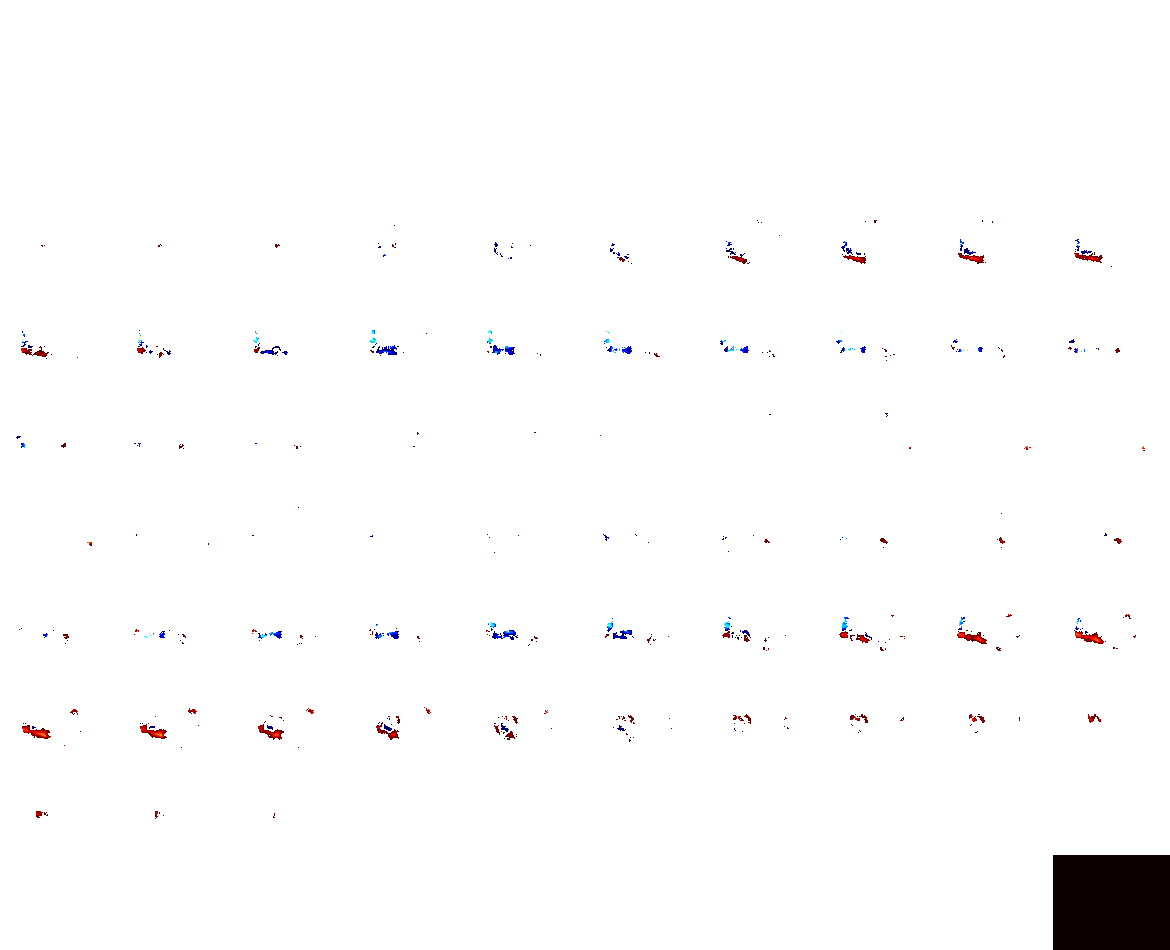

In [5]:
# Make an interactive viewer
view_img(weight_img, threshold=thres,
         colorbar=False, annotate=False)